In [7]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cftime
import copy
from collections import OrderedDict

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [8]:
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])
try:
    data
except NameError:
    data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [3]:
client=Client("tcp://10.6.43.39:8786")
client

Client Scheduler: tcp://127.0.0.1:33633 Dashboard: /proxy/33299/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [5]:
# Selecting values for Drake Passage
xmin = -69.9 
ymin = -71.6
ymax = -51.0

In [14]:
def add_cycles():
    cycle_dates = [1778, 1838, 1898]
    ylims=plt.gca().get_ylim()
    for cd in cycle_dates:
        plt.plot([cftime.datetime(cd,1,1),cftime.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
    plt.gca().set_ylim(ylims)

In [10]:
# calculate mass transport timeseries (Sv)
for ekey in data.keys():
    expt = data[ekey]['expt']
    print(expt)
    offset = data[ekey]['offset']
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='tx_trans_int_z')
    darray = var_search.to_dask()
    darray = darray['tx_trans_int_z']
    if offset:# shift time axis of darray by 'offset'
        darray = darray.assign_coords(time = darray.time - xr.coding.cftime_offsets.to_offset(offset))
    
    transport = darray.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')
    transport_mean = transport.resample(time='A').mean('time')/1e6/1036
    data[ekey]['transport_mean'] = transport_mean
    

1deg_jra55v13_iaf_spinup1_B1
025deg_jra55v13_iaf_gmredi6
01deg_jra55v13_iaf


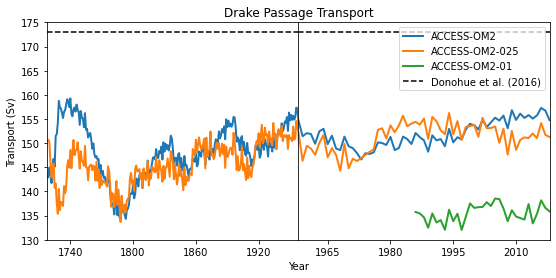

In [16]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(wspace=0.0)

for ekey in data.keys():
    transport_mean = data[ekey]['transport_mean']
    transport_mean.plot(ax = ax[0],label=data[ekey]['desc'], linewidth=2)
    transport_mean.plot(ax = ax[1],label=data[ekey]['desc'], linewidth=2)

ax[0].plot([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
ax[1].plot([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
l2=ax[1].legend(fancybox=True, framealpha=0.75)
ax[0].set_ylim([130, 175])
ax[0].set_xlim([cftime.datetime(1718,1,1),cftime.datetime(1957,12,31)])
#ax[0].set_xticks([cftime.datetime(1730,1,1), cftime.datetime(1740,1,1), cftime.datetime(1750,1,1), cftime.datetime(1770,1,1), 
#               cftime.datetime(1780,1,1), cftime.datetime(1790,1,1), cftime.datetime(1810,1,1), cftime.datetime(1820,1,1), 
#               cftime.datetime(1830,1,1), cftime.datetime(1850,1,1), cftime.datetime(1860,1,1), cftime.datetime(1870,1,1),
#               cftime.datetime(1890,1,1), cftime.datetime(1900,1,1), cftime.datetime(1910,1,1), cftime.datetime(1930,1,1),
#               cftime.datetime(1940,1,1), cftime.datetime(1950,1,1)], minor=True)
ax[1].set_xlim([cftime.datetime(1958,1,1),cftime.datetime(2017,12,31)])
ax[0].set_ylim([130, 175])
ax[0].set_title('')
ax[1].set_title('Drake Passage Transport',position=(0.0,1.0))
ax[0].set_xlabel('')
ax[1].set_xlabel('Year',position=(0.0,1.0))
ax[0].set_ylabel('Transport (Sv)')
ax[1].set_yticks([])
ax[1].set_ylabel('')

add_cycles()